In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time
import xgboost as xgb
from sklearn.model_selection import train_test_split
import datetime as dt
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
import numpy as np
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt
from matplotlib import ticker
import seaborn as sns

# https://machinelearningmastery.com/data-preparation-gradient-boosting-xgboost-python/

In [2]:
path1 = 'https://gen10datafund2202.blob.core.windows.net/jedscontainer/911_Calls_For_Service.csv'
path2 = 'https://opendata.arcgis.com/api/v3/datasets/4f49eb825f564efa9a23cd103c4ba13b_0/downloads/data?format=csv&spatialRefId=4326'
detroit_911 = pd.read_csv(path1, thousands = ",")#, nrows = 100000)

109.6916386


## Clean the Data

In [3]:
# Make a copy of the dataframe so that I don't have to redownload it every time I want to refresh.
detroit_df = detroit_911.copy()

# Count all the null values in the columns
null_values = detroit_911.isnull().sum()
#print('Null values prior to dropping columns.')
#print(null_values)

# Drop columns that will not be used in algorithm
detroit_df.drop(
    columns = [
        'incident_id',
        'zip_code',
        'oid',
        'respondingunit',
        'agency',
        'X',
        'Y',
        'longitude',
        'latitude',
        'incident_address',
        'block_id',
        'category'
    ], inplace = True)

#print('\nNull values after dropping columns')
#print(detroit_df.isnull().sum())


mapped_priorities = detroit_df.groupby(by = ['priority'])['calldescription'].apply(lambda x: ', '.join(x)).reset_index()
mapped_priorities['calldescription'] = mapped_priorities['calldescription'].apply(lambda x: ", ".join(_.strip() for _ in set(x.split(","))))

### Fix Missing Priorities

In [4]:
priority_dict = {}
for priority in mapped_priorities['priority'].unique():
    priority_dict[priority] = mapped_priorities[(mapped_priorities.priority == priority)]['calldescription'].values.tolist()[0]

del priority_dict[" "]

def get_priority(current_priority, call_descrip):
    if current_priority != " ":
        return current_priority
    for key in priority_dict.keys():
        if call_descrip in priority_dict[key]:
            return key
        
    return 'FAIL'

detroit_df['new_priority'] = detroit_df.apply(lambda row: get_priority(row.priority, row.calldescription), axis = 1)

detroit_df.drop(columns = ['priority'], inplace = True)
detroit_df.rename(columns = {'new_priority': 'priority'}, inplace = True)


In [5]:
# for column in detroit_df.columns:
#     print(f'{column}\nNumber of Values: {len(detroit_df[column].unique())}\n')

In [6]:
detroit_df.drop(columns = ['totaltime','totalresponsetime'], inplace = True)


### Convert timestamp to weekday

In [7]:
def return_weekday(time_stamp):
    time = dt.datetime.strptime(time_stamp, '%Y/%m/%d %H:%M:%S+00').date()
    return dt.datetime.strftime(time, '%A')
    
detroit_df['weekday'] = detroit_df['call_timestamp'].apply(lambda x: return_weekday(x))

In [8]:
def get_daypart(time_stamp):
    time = dt.datetime.strptime(time_stamp, '%Y/%m/%d %H:%M:%S+00')
    time = dt.datetime.strftime(time, '%H:%M:%S')
    if time < "06:00":
        time_of_day = "Early Morning"
    elif time >= "06:00" and time < "10:00":
        time_of_day = "Morning"
    elif time >= "10:00" and time < "12:00":
        time_of_day = "Late Morning"
    elif time >= "12:00" and time < "15:00":
        time_of_day = "Afternoon"
    elif time >= "15:00" and time < "18:00":
        time_of_day = "Late Afternoon"
    elif time >= "18:00" and time < "21:00":
        time_of_day = "Early Evening"
    elif time >= "21:00":
        time_of_day = "Evening"
    else:
        time_of_day = "FAILED"
    return time_of_day

detroit_df['day_part'] = detroit_df['call_timestamp'].apply(lambda x: get_daypart(x))


In [9]:
detroit_df.day_part.unique()

array(['Morning', 'Late Morning', 'Afternoon', 'Late Afternoon',
       'Early Evening', 'Evening', 'Early Morning'], dtype=object)

In [10]:
detroit_df.head()

,callcode,calldescription,call_timestamp,precinct_sca,officerinitiated,intaketime,dispatchtime,traveltime,time_on_scene,neighborhood,council_district,priority,weekday,day_part
0,825030,DISTURBANCE,2016/09/20 09:36:12+00,910A,No,2.2,528.6,15.5,120.5,Wade,4.0,3,Tuesday,Morning
1,811020,AUTO X UNK INJ / IMPAIRED,2016/09/20 09:46:32+00,1201,No,2.7,5.2,6.4,59.1,Tri-Point,2.0,2,Tuesday,Morning
2,374030,RECOVER AUTO,2016/09/20 09:48:24+00,123B,No,4.9,NaN,NaN,NaN,Oak Grove,2.0,3,Tuesday,Morning
3,825030,DISTURBANCE,2016/09/20 09:50:29+00,0207,No,1.4,3.4,7.6,41.7,We Care Community,7.0,3,Tuesday,Morning
4,374030,RECOVER AUTO,2016/09/20 09:54:37+00,28A,No,3.0,1645.3,NaN,NaN,Barton-McFarland,7.0,3,Tuesday,Morning


In [11]:
detroit_df.drop(columns = ['callcode','call_timestamp','precinct_sca'], inplace = True)

In [12]:
detroit_df.drop(columns = ['calldescription'], inplace = True)
detroit_df

,officerinitiated,intaketime,dispatchtime,traveltime,time_on_scene,neighborhood,council_district,priority,weekday,day_part
0,No,2.2,528.6,15.5,120.5,Wade,4.0,3,Tuesday,Morning
1,No,2.7,5.2,6.4,59.1,Tri-Point,2.0,2,Tuesday,Morning
2,No,4.9,NaN,NaN,NaN,Oak Grove,2.0,3,Tuesday,Morning
3,No,1.4,3.4,7.6,41.7,We Care Community,7.0,3,Tuesday,Morning
4,No,3.0,1645.3,NaN,NaN,Barton-McFarland,7.0,3,Tuesday,Morning
...,...,...,...,...,...,...,...,...,...,...
2551995,No,2.2,19.3,9.1,48.0,Oakman Blvd Community,2.0,3,Monday,Late Morning
2551996,No,1.9,NaN,NaN,NaN,North Corktown,6.0,2,Monday,Late Morning
2551997,No,1.1,20.6,5.1,152.7,Oakman Blvd Community,7.0,3,Monday,Late Morning
2551998,No,0.9,0.3,7.7,213.3,Warrendale,7.0,1,Monday,Late Morning


In [13]:
detroit_df[(detroit_df[detroit_df.columns[7]] == ' ')]

,officerinitiated,intaketime,dispatchtime,traveltime,time_on_scene,neighborhood,council_district,priority,weekday,day_part


In [14]:
backup_detroit = detroit_df.copy()

## To avoid overwriting detroit_df run from this point

In [15]:
backup_detroit.head()

,officerinitiated,intaketime,dispatchtime,traveltime,time_on_scene,neighborhood,council_district,priority,weekday,day_part
0,No,2.2,528.6,15.5,120.5,Wade,4.0,3,Tuesday,Morning
1,No,2.7,5.2,6.4,59.1,Tri-Point,2.0,2,Tuesday,Morning
2,No,4.9,NaN,NaN,NaN,Oak Grove,2.0,3,Tuesday,Morning
3,No,1.4,3.4,7.6,41.7,We Care Community,7.0,3,Tuesday,Morning
4,No,3.0,1645.3,NaN,NaN,Barton-McFarland,7.0,3,Tuesday,Morning


In [16]:
detroit_df = backup_detroit.copy()

In [17]:
detroit_df_subset = detroit_df.head(5000)

<AxesSubplot:xlabel='time_on_scene', ylabel='Count'>

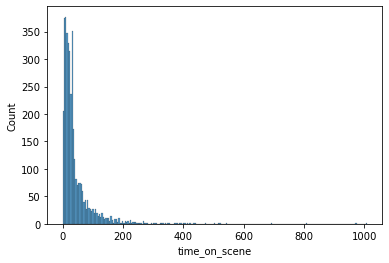

In [18]:
sns.histplot(data = detroit_df_subset, x='time_on_scene')

In [19]:
detroit_df['on_scene_2_hours'] = detroit_df['time_on_scene'].apply(lambda x: 1 if x > 32.769917676311266 else 0)

In [20]:
detroit_df['time_on_scene'].mean()

32.769917676311266

In [21]:
detroit_df.drop(columns = ['time_on_scene'], inplace = True)

In [22]:
X = detroit_df.drop(columns = ['on_scene_2_hours']).copy()

In [23]:
y_res = detroit_df['on_scene_2_hours'].copy()

In [24]:
X.select_dtypes('object')

,officerinitiated,neighborhood,priority,weekday,day_part
0,No,Wade,3,Tuesday,Morning
1,No,Tri-Point,2,Tuesday,Morning
2,No,Oak Grove,3,Tuesday,Morning
3,No,We Care Community,3,Tuesday,Morning
4,No,Barton-McFarland,3,Tuesday,Morning
...,...,...,...,...,...
2551995,No,Oakman Blvd Community,3,Monday,Late Morning
2551996,No,North Corktown,2,Monday,Late Morning
2551997,No,Oakman Blvd Community,3,Monday,Late Morning
2551998,No,Warrendale,1,Monday,Late Morning


In [25]:
y_res.unique()

array([1, 0], dtype=int64)

In [26]:
X_encoded = pd.get_dummies(X)
# detroit_dummied.shape

# It is better to use One-Hot-Encoding than get_dummies because OHE saves the exploded categories into its object, but we are using get_dummies for ease



In [27]:
X_encoded.head()

,intaketime,dispatchtime,traveltime,council_district,officerinitiated_No,officerinitiated_Yes,neighborhood_Airport Sub,neighborhood_Arden Park,neighborhood_Aviation Sub,neighborhood_Bagley,...,weekday_Thursday,weekday_Tuesday,weekday_Wednesday,day_part_Afternoon,day_part_Early Evening,day_part_Early Morning,day_part_Evening,day_part_Late Afternoon,day_part_Late Morning,day_part_Morning
0,2.2,528.6,15.5,4.0,1,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,1
1,2.7,5.2,6.4,2.0,1,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,1
2,4.9,NaN,NaN,2.0,1,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,1
3,1.4,3.4,7.6,7.0,1,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,1
4,3.0,1645.3,NaN,7.0,1,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,1


In [28]:
X_encoded.fillna(0, inplace = True)

In [29]:
print(sum(y_res)/len(y_res))

0.23170807210031347


In [72]:
def check_dmatrix(X,y, size):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42, stratify = y)

    clf_xgb = xgb.XGBClassifier(objective='binary:logistic', missing=0, seed=42, gamma = .25, learn_rate = .1, max_depth = 4, reg_lambda = 0.1)
    clf_xgb.fit(X_train, 
                y_train, 
                verbose = True,
                early_stopping_rounds=10, 
                eval_metric='auc',
                eval_set=[(X_test, y_test)]
               )
    
    accuracy = clf_xgb.score(X_test, y_test)
    scores.append([size,accuracy])

X_encoded.isna().sum().sum()

scores = []
#sizes = [100,1000,10000,20000,30000,40000,50000,60000,70000,80000,90000,100000] + [_ for _ in range(200000,2500000,100000)]
sizes = [100000,500000]
for size in sizes:
    X_subset = X_encoded.head(size)
    y_subset = y_res.head(size)

    ## converting to numpy array
    # X_subset = X_subset.to_numpy()
    # y_subset = y_subset.to_numpy()
    
    # print(X_subset)
    check_dmatrix(X_subset,y_subset, size)
    print(f'Current Size: {size}')
    # print('Not Running the Model currently')
    



C:\Users\jared\anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\jared\anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[17:56:46] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "learn_rate" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation_0-auc:0.68999
[1]	validation_0-auc:0.69768
[2]	validation_0-auc:0.70272
[3]	validation_0-auc:0.70678
[4]	validation_0-auc:0.70841
[5]	validation_0-auc:0.71124
[6]	validation_0-auc:0.71282
[7]	validation_0-auc:0.71396
[8]	validation_0-auc:0.71553
[9]	validation_0-auc:0.71675
[10]	validation_0-auc:0.71796
[11]	validation_0-auc:0.71871
[12]	validation_0-auc:0.72083
[13]	validation_0-auc:0.72108
[14]	validation_0-auc:0.72140
[15]	validation_0-auc:0.72171
[16]	validation_0-auc:0.72198
[17]	validation_0-auc:0.72237
[18]	validation_0-auc:0.72270
[19]	validation_0-auc

C:\Users\jared\anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\jared\anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[17:57:02] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "learn_rate" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation_0-auc:0.71768
[1]	validation_0-auc:0.72263
[2]	validation_0-auc:0.72546
[3]	validation_0-auc:0.72793
[4]	validation_0-auc:0.73037
[5]	validation_0-auc:0.73230
[6]	validation_0-auc:0.73436
[7]	validation_0-auc:0.73587
[8]	validation_0-auc:0.73653
[9]	validation_0-auc:0.73702
[10]	validation_0-auc:0.73780
[11]	validation_0-auc:0.73845
[12]	validation_0-auc:0.73967
[13]	validation_0-auc:0.74042
[14]	validation_0-auc:0.74054
[15]	validation_0-auc:0.74090
[16]	validation_0-auc:0.74115
[17]	validation_0-auc:0.74130
[18]	validation_0-auc:0.74145
[19]	validation_0-auc

In [70]:
score_frame = pd.DataFrame(scores, columns = ['size','accuracy'])

In [71]:
score_frame

,size,accuracy
0,100000,0.70720
1,500000,0.73948
